In [5]:
# --- Latent Diffusion Interactive Playground ---
# Run this in a Jupyter notebook cell.
import sys
sys.path.append(r"C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\repositories\ImagiNav")
import torch
from modules.diffusion import LatentDiffusion  # adjust import to your project structure
import matplotlib.pyplot as plt


In [ ]:
# --- Load pre-trained model ---
config_path = r"C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\repositories\ImagiNav\config\diffusion_1.yml"
device = "cuda" if torch.cuda.is_available() else "cpu"

model = LatentDiffusion.from_config(config_path, device=device)
print(f"scheduler steps = {model.scheduler.num_steps}")
print(f"Loaded LatentDiffusion model on {device}")
print(f"Latent shape: {model.latent_shape}")

# --- Sampling parameters ---
batch_size = 4
num_steps = 200  # fewer steps for faster preview
generate_images = True  # if False, returns latents instead
use_conditioning = False  # toggle if you have cond maps

cond = None
if use_conditioning:
    # Example placeholder conditioning (replace with real mixer output)
    C_cond, H, W = 16, model.latent_shape[1], model.latent_shape[2]
    cond = torch.randn(batch_size, C_cond, H, W, device=device)


[Encoder] Layer 0: in=3, out=32, size=256x256
[Encoder] Layer 1: in=32, out=64, size=128x128
[Encoder] Layer 2: in=64, out=128, size=64x64
[Encoder] Conv output: 128x64x64
[Encoder] Latent output: 4x64x64
[Decoder] Latent input: 4x64x64
[Decoder] Decoder start: 128x64x64
[Decoder] Layer 0: in=128, out=128, size=128x128
[Decoder] Layer 1: in=128, out=64, size=256x256
[Decoder] Layer 2: in=64, out=32, size=512x512
[Decoder] Final output: 3x512x512
scheduler steps = 200
Loaded LatentDiffusion model on cpu
Latent shape: (4, 64, 64)


Generating...


Diffusion sampling: 100%|██████████| 200/200 [01:14<00:00,  2.70it/s]


Decoding...


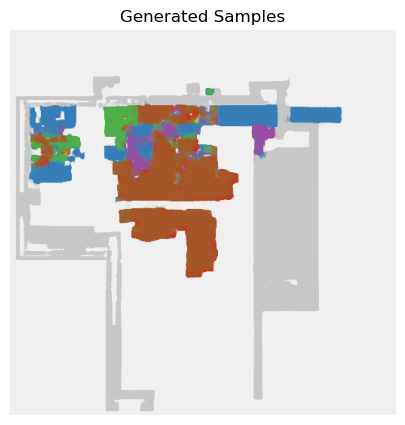

In [12]:

# --- Generate samples ---
samples = model.sample(
    batch_size=batch_size,
    image=generate_images,
    cond=cond,
    num_steps=num_steps,
    device=device
)

# --- Display results ---
if generate_images:
    imgs = samples.detach().cpu()
    grid = torch.cat([img for img in imgs], dim=2).permute(1, 2, 0)
    plt.figure(figsize=(10, 5))
    plt.imshow(grid)
    plt.axis("off")
    plt.title("Generated Samples")
    plt.show()
else:
    print("Generated latent samples:", samples.shape)
